# Model Analysis of Middle Low German and Nowegian Nynorsk

In this analysis we will walk through the results of the baseline neural transducer models for two target low-resource languages, Middle Low German and Norwegian Nynorsk, as well as their source languages, English, German, and Icelandic.

Ontop of a basic Analysis we will be taking an in-depth look at how a lemma is effected in the predictions and training, and by training models with custom training data, hope to gain an insight into what source languages pair with the target languages best, as well as how the models react to adding more data to train on.

In [3]:
# packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# lists
languages = 'gml nno deu eng isl'.split(' ')
baseraw = pd.read_csv('scraped_data/2020-07-10-tsv.predictions.csv')

# column for if full lemma is in truth word
baseraw['is_lemma'] = [1 if str(row[6]) in str(row[5]) else 0 for row in baseraw.itertuples()]

baseraw.head()

,family,language,model,prediction,truth,lemma,tag,loss,distance,is_correct,is_lemma
0,germanic,gml,hall-mono-hmm,achtede,achtede,achten,V;IND;SG;3;PST\n,0.006583,0,1,0
1,germanic,gml,hall-mono-hmm,vrîen,vrîen,vrie,ADJ;GEN;LGSPEC1\n,0.036813,0,1,0
2,germanic,gml,hall-mono-hmm,spö̂dede,spö̂dede,spoden,V;SBJV;SG;1;PST\n,0.001421,0,1,0
3,germanic,gml,hall-mono-hmm,jachtereden,jachtereden,jachteren,V;IND;PL;PST\n,0.001089,0,1,0
4,germanic,gml,hall-mono-hmm,jachterest,jachterest,jachteren,V;SBJV;SG;2;PRS\n,0.000505,0,1,0


As shown, this is what the raw data from our base predictions looks like. This data consists of every prediction, ground truth, lemma, and tag for the development data for all the languages we want to take a look at. There are also additional columns that are derived from those 4 mentioned columns.

# Simple analysis

Lets take a look at some basic statistics of all our languages, trying to see if we can find any patterns in the test data, that can be utilized for different training methods.

## How well did languages perform?

Lets start with looking at the mean accuracy for each language.

In [40]:
# get mean accuracy, loss, distance
avg_langs = baseraw.groupby(['language']).agg({'prediction':'count', 'is_correct':'mean', 'distance':'mean', 'loss':'mean'}).reset_index()
avg_langs.columns = ['language', 'nwords tested', 'mean accuracy', 'mean distance', 'mean loss']
# get actual nwords, as the first part was not grouped by model
avg_langs['nwords tested'] = baseraw.groupby(['language', 'model']).agg({'prediction':'count'})['prediction'].reset_index().groupby('language').agg({'prediction':'max'}).reset_index()['prediction']
avg_langs['mean accuracy'] = avg_langs['mean accuracy'] * 100

avg_langs.sort_values(by=['language'])


,language,nwords tested,mean accuracy,mean distance,mean loss
0,deu,14201,97.829378,0.051387,0.387351
1,eng,11553,96.516056,0.088181,0.398252
2,gml,127,60.826772,1.137795,0.524684
3,isl,7690,96.605982,0.073700,0.391719
4,nno,1443,84.736660,0.241511,0.440174


Here we can see how many words each development data test set had. Which shows that Middle Low German (gml) was only tested on 127 words. We can also see the mean accuracy for each language.

We notice that the mean accuracy for the source languages are > 96%, while the target languages tend to be lower. We can also see that Middle Lowe German had the highest mean leveshtein distance with 1.1, it also has the highest mean loss at 0.52.

## How well did individual model types perform?

Lets dive one level deeper and take a look at how these langauges did in comparison to the model types.

In [49]:
# aggregating dataframe for number of words, mean loss, and mean distance
aggdf = baseraw.groupby(['language','model']).agg({'prediction':'count', 'is_lemma':'mean', 'loss':'mean', 'distance':'mean', 'is_correct':'mean'}).reset_index()
# rename
aggdf.columns = ['language', 'model', 'nwords tested', 'lemma_in_word', 'meanloss', 'meandist', 'accuracy']
aggdf['accuracy'] = aggdf['accuracy'] * 100
aggdf['lemma_in_word'] = aggdf['lemma_in_word'] * 100
aggdf['nwords trained'] = [10000, 10000, 99405, 99405, 10000, 10000, 80864, 80864, 10000, 10000, 890, 890, 10000, 10000, 53841, 53841, 10000, 10000, 10101, 10101]

aggdf[['language', 'model', 'nwords trained', 'nwords tested', 'lemma_in_word', 'meanloss', 'meandist', 'accuracy']]

,language,model,nwords trained,nwords tested,lemma_in_word,meanloss,meandist,accuracy
0,deu,hall-mono-hmm,10000,14201,61.523836,0.005871,0.075276,98.331103
1,deu,hall-transformer,10000,14201,61.523836,0.769088,0.038448,96.894585
2,deu,mono-hmm,99405,14201,61.523836,0.005425,0.061686,98.591648
3,deu,transformer,99405,14201,61.523836,0.769019,0.030139,97.500176
4,eng,hall-mono-hmm,10000,11553,87.881935,0.020817,0.149225,95.654808
5,eng,hall-transformer,10000,11553,87.881935,0.776552,0.062754,96.918549
6,eng,mono-hmm,80864,11553,87.881935,0.017318,0.081364,96.485761
7,eng,transformer,80864,11553,87.881935,0.778323,0.059379,97.005107
8,gml,hall-mono-hmm,10000,127,11.811024,0.227857,1.220472,54.330709
9,gml,hall-transformer,10000,127,11.811024,0.814902,0.944882,65.354331


## Initial thoughts

Middle Low German

* Has a very low amount of development data
* Has the lowest accuracy out of all languages
    + hall-transformer seemed to perform the best out of the models at 65.354%

Norwegian Nynorsk

* A low amount of development data, although not the lowest
* Good accuray results, with the transformer taking the lead at 88.704%

English, German, Icelandic

* Each having a good amount of development data
* All accuracies are >= 95%
    + For icelandic, mono-hmm did the best at 97%
    + For german, mono-hmm did the bests at 98.592%
    + For english, transformer did the best at 97%

# Correlations and Pearsons r

Next lets start by taking a look the matchups between the distance, loss, number of testing words, and accuracy

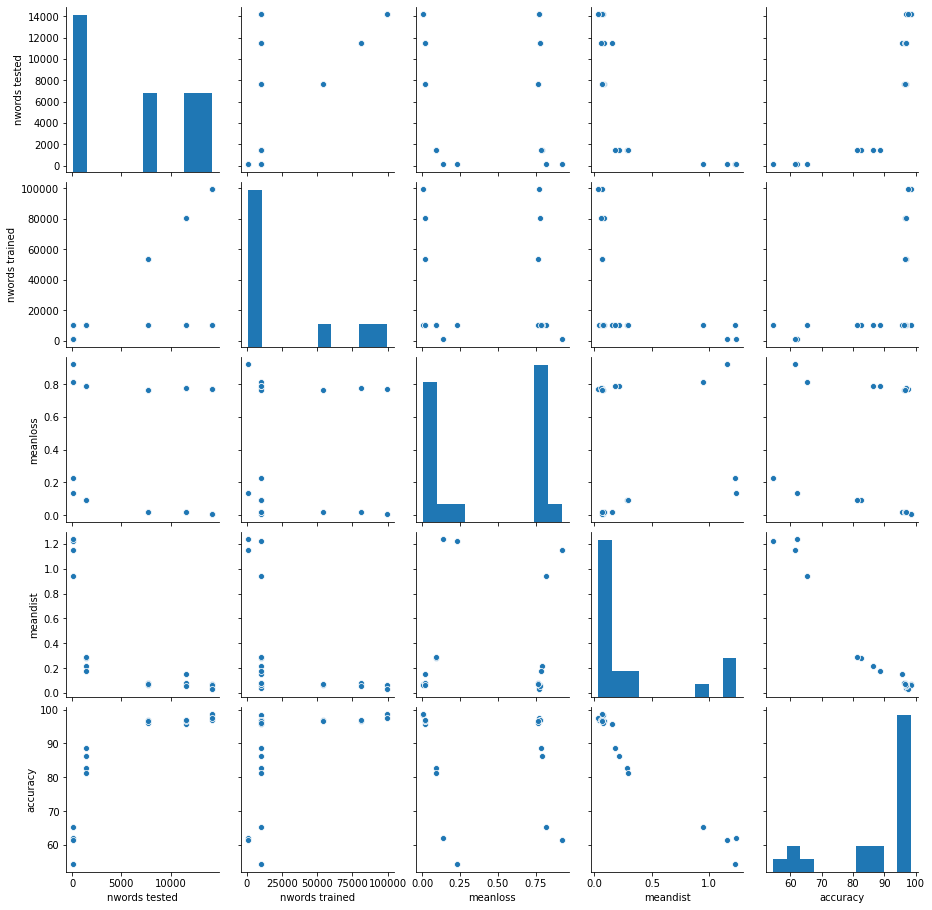

In [45]:
sns.pairplot(aggdf[['nwords tested', 'nwords trained', 'meanloss', 'meandist', 'accuracy']])
plt.show()

In [48]:
## pearsons r squared
aggdf[['nwords tested', 'nwords trained', 'meanloss', 'meandist', 'accuracy']].corr()**2

,nwords tested,nwords trained,meanloss,meandist,accuracy
nwords tested,1.000000,0.330275,0.013591,0.523978,0.668623
nwords trained,0.330275,1.000000,0.004592,0.188719,0.227895
meanloss,0.013591,0.004592,1.000000,0.003196,0.006263
meandist,0.523978,0.188719,0.003196,1.000000,0.953489
accuracy,0.668623,0.227895,0.006263,0.953489,1.000000


## Correlation thoughs

Pearsons r squared is being used here.

* Mean levenshtein distance and accuracy have the highest R^2 value of ~0.95, this is an indicator that focusing on improving the metric might be the best way forward. A lower distance tends to show a higher accuracy.

* The number of words is also heavily correlated to the accuracy and the mean distance, an attempt to boost the number of words might prove beneficial

* The mean loss seems to have little to do with the models accuracy, although it is most likely a statistically significant r squared value.

# Does the full lemma appear in the inflected word?

Now that we have a general idea of how the baseline model performed, lets dive deeper into distinguishing a pattern in the two target languages: Middle Low German (gml) and Norwegian Nynorsk (nno).

One factor to the language performance could be distinguishing whether the full lemma exists in the true word or not. It might make it easier for the Neural Network to correctly predict a word, if the lemma is unchanged and fully in the inflected word.

Lets start digging into this idea.

In [34]:
# aggregate dataframe into each language -> model
agglemma = baseraw[baseraw['is_lemma'] == 1].groupby(['language', 'model']).agg({'prediction':'count', 'loss':'mean', 'distance':'mean', 'is_correct':'mean'}).reset_index()
agglemma.columns = ['language', 'model', 'nlemmas', 'meanloss', 'meandist', 'accuracy']

# math to compare results
agglemma['%acc_diff'] = (agglemma['accuracy']*100 - aggdf['accuracy'])
# agglemma['dist_diff'] = agglemma['meandist'] - aggdf['meandist']
# agglemma['loss_diff'] = agglemma['meanloss'] - aggdf['meanloss']
agglemma['%lemma'] = agglemma['nlemmas'] / aggdf['numwords']*100

# the proportion of words that are incorrect and have the full lemma, to the total incorrect words
false = baseraw[baseraw.is_correct == 0]
falseagg = false[false.is_lemma == 1].groupby(['language', 'model']).agg({'prediction':'count'}).reset_index()
falseagg.columns = ['language', 'model', 'nwords']

# finding proportion of false words that contain the full lemma
false_lemma = [n for n in falseagg['nwords']]
false = [ n for n in false.groupby(['language', 'model']).agg({'prediction':'count'}).reset_index()['prediction']]
agglemma['%false&lemma'] = [false_lemma[i] / false[i] * 100 for i in range(len(false))]


agglemma = agglemma[['language', 'model', 'nlemmas', '%lemma', '%false&lemma', '%acc_diff']]

agglemma[[True if lang in ('gml', 'nno') else False for lang in agglemma.language]]

,language,model,nlemmas,%lemma,%false&lemma,%acc_diff
8,gml,hall-mono-hmm,15,11.811024,12.068966,-0.997375
9,gml,hall-transformer,15,11.811024,13.636364,-5.354331
10,gml,mono-hmm,15,11.811024,12.500000,-2.204724
11,gml,transformer,15,11.811024,14.285714,-8.083990
16,nno,hall-mono-hmm,1179,81.704782,72.908367,1.872689
17,nno,hall-transformer,1179,81.704782,77.157360,0.759832
18,nno,mono-hmm,1179,81.704782,71.851852,2.256396
19,nno,transformer,1179,81.704782,73.006135,1.202612


From this chart we can see the difference in the testing data after subsetting for words where the lemma appears unchanged in the inflected word. One thing that we notice is that only 11% of the Middle Low German development data is in this subset, while 81% is in Norwegian Nynorsk.

We can also see that the accuracy dropped for all model types in Middle Low German, suggesting that this is a weak spot in the training. However, for Norwegian Nynorsk, the accuracy increased, suggesting that this might not be the best approach to helping this language train.

Nonetheless, lets run some more models and see what results we get!

# Training Augmentation

One base method for training augmentation was done here. We had taken the target languages, Middle Low German and Norwegian Nynorsk and have added an additional buffer of data to train from the source languages, English, German, Icelandic. The amount of data added is a direct percentage of the existing target language, for example we added an additional 25%, 50%, .., 200% training data, when allowable. This data was randomly chosen from a subset of the source languages. The subset is the words where the lemma is in the inflected word, unchanged.

This was done to test the hypothesis that if we augment the training data with a subset of source data, we can achieve a higher accuracy in training. Ultimately supporting the idea that targeted language feature modifications can help improve low-resource languages.

## Basic Overview

Lets start by taking a look at how each language performed.

In [4]:
# reading in and adding columns for the lemma prediction raw data
augraw = pd.read_csv('scraped_data/8-13-20.lemma.dev.predictions.csv')
trglang = [lang.split('+')[0] for lang in augraw.language]
srclang = [lang.split('+')[-1] for lang in augraw.language]
percent_added = [int(lang.split('+')[1].split('p')[0]) for lang in augraw.language] 

augraw['target'], augraw['add_lang'], augraw['%added'] = trglang, srclang, percent_added
# column for if full lemma is in truth word
augraw['is_lemma'] = [1 if str(row[6]) in str(row[5]) else 0
        for row in augraw.itertuples()]


# reading in basic language model data
basic_models = pd.read_csv('scraped_data/2020-07-10-tsv.predictions.csv')
aggog = basic_models.groupby(['language','model']).agg({'loss':'mean', 'distance':'mean', 'is_correct':'mean'}).reset_index()
aggog.columns = ['language', 'model', 'meanloss', 'meandist', 'accuracy']

# get gml and nno baseline accuracies
gml_acc = float(aggog[aggog.language == 'gml'].groupby(['language']).agg({'accuracy':'mean'}).reset_index()['accuracy'])*100
nno_acc = float(aggog[aggog.language == 'nno'].groupby(['language']).agg({'accuracy':'mean'}).reset_index()['accuracy'])*100
base_acc = [gml_acc, nno_acc]

# aggregating dataframe for number of words, mean loss, and mean distance
agglemma = augraw.groupby(['language','model']).agg({'target':'max', 'add_lang':'max', '%added':'max', 'loss':'mean', 'distance':'mean', 'is_correct':'mean'}).reset_index()
# rename
agglemma.columns = ['language', 'model', 'target', 'add_lang', '%added', 'meanloss', 'meandist', 'accuracy']

agglemma['accuracy'] = agglemma['accuracy'] * 100

comparison = agglemma.groupby(['target']).agg({'accuracy':'mean'}).reset_index()
comparison.columns = ['target language', 'mean augmented accuracy']
comparison['mean baseline accuracy'] = base_acc
comparison

,target language,mean augmented accuracy,mean baseline accuracy
0,gml,65.485564,60.826772
1,nno,86.050211,84.736660


As we can see, with the addition of another language for training the models perform, on average, better than the baseline.

## Best language to add for training

Lets take a look into which additional language performed the best for each target language.

In [6]:
lang_comparison = agglemma.groupby(['target','add_lang']).agg({'accuracy':'mean'}).reset_index()
lang_comparison.columns = ['target language', 'addition language', 'mean augmented accuracy']
lang_comparison['mean baseline accuracy'] = [acc for item in [[accuracy for i in range(4)] for accuracy in base_acc] for acc in item]

lang_comparison[['target language', 'addition language', 'mean augmented accuracy']]

,target language,addition language,mean augmented accuracy
0,gml,deu,65.157480
1,gml,eng,66.437008
2,gml,isl,64.714567
3,gml,nno,65.682415
4,nno,deu,85.635086
5,nno,eng,86.204336
6,nno,isl,86.235274
7,nno,nno,86.321899


Here we can see that for both target languages, the custom training models out performed the baseline.

For Middle Low German the best performing additional language was Norwegian Nynorsk coming, with an average accuracy of 65.06% compared to the baseline of 60.83%.

For Norwegian Nynorsk the best performing addition language was FIXING NNO+NNO

## What percentage of the target language does best?

Lets take a look at the how each target language dealt with additional training data, on average. We can hope to gain insights on how much data to buffer with these low-resource languages.

In [19]:
# change agglemma to bins of 25%
agglemma['%added'] = [p if p%25==0 else (p+(25-(p%25))) for p in agglemma['%added']]

percent_comparison = agglemma.groupby(['target', '%added']).agg({'accuracy':'mean'}).reset_index()
percent_comparison.columns = ['target language', 'percent of target', 'mean augmented accuracy']
# percent_comparison['mean baseline accuracy'] = [acc for item in [[accuracy for i in range(9)] for accuracy in base_acc] for acc in item]


percent_comparison['mean baseline accuracy'] = [acc for item in [[accuracy for i in range(8)] for accuracy in base_acc] for acc in item][:-1]
percent_comparison

,target language,percent of target,mean augmented accuracy,mean baseline accuracy
0,gml,25,64.468504,60.826772
1,gml,50,64.173228,60.826772
2,gml,75,64.566929,60.826772
3,gml,100,65.452756,60.826772
4,gml,125,67.322835,60.826772
5,gml,150,65.452756,60.826772
6,gml,175,66.404199,60.826772
7,gml,200,66.535433,60.826772
8,nno,25,85.732848,84.736660
9,nno,50,86.053361,84.736660


Here if we ignore which language was added, we can see that adding more language for training Middle Low German produces a more accurate model. While, for Norwegian Nynorsk it seems that around an additional 75% training data improves performance.

## Does this change depending on the language?

Lets break this down even further into seeing if these changes in accuracy depends on the language being added.

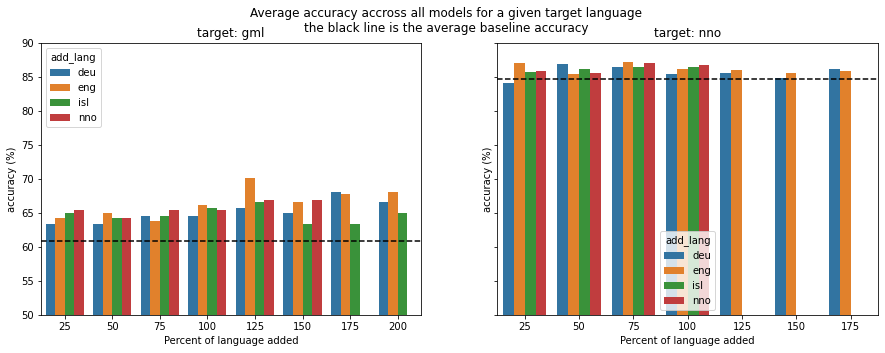

In [6]:
avg_lang = agglemma.groupby(['target', '%added', 'add_lang']).agg({'accuracy':'mean', 'meanloss':'mean', 'meandist':'mean'}).reset_index()

avg_lang.columns = ['target', '%added', 'add_lang', 'avg_acc', 'avg_loss', 'avg_dist']

avg_lang

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex= False, sharey=True)

for i,tlang in enumerate(['gml', 'nno']):
    targetdf = avg_lang[tlang == avg_lang.target]
    # group into bins of 25, graph is unreadble otherwise..
    targetdf['%added'] = [p if p%25==0 else (p+(25-(p%25))) for p in targetdf['%added']]
    p1 = sns.barplot(data=targetdf.sort_values(by=['%added', 'add_lang']), x='%added', y='avg_acc', hue='add_lang', ax= ax[i]).set_title(f"target: {tlang}")
    ax[i].set_xlabel("Percent of language added")
    ax[i].set_ylabel("accuracy (%)")
    ax[i].axhline(base_acc[i], ls='--', color='black') # sets line in graph for baseline comparison

# ax[1].get_legend().set_visible(False)  
# plt.xlim([0, 100])
plt.ylim([50, 90])
plt.suptitle('Average accuracy accross all models for a given target language\nthe black line is the average baseline accuracy')

# to save
plt.savefig('target.accuracy.percent.png')

plt.show()

Here we can see that most of the additional languages performed, on average, better than the baseline. Howevewr, some languages are improving with more training data.

## Comparing by model type and target languages

Taking this even further, lets break it down by model type and language added. Can we see any trends for the accuracy depending on the model, additional language, or the percent of the target language added?

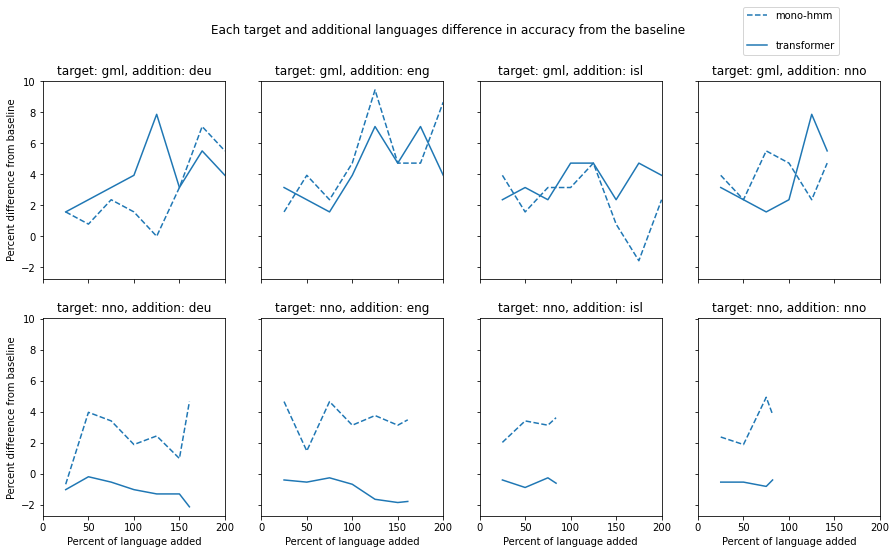

In [7]:
def calculate(row, baseline):
    '''takes new row and subracts baseline results'''
    baseline = baseline[baseline.language == row['target']]
    baseline = baseline[baseline.model == row['model']]
    acc_diff = float(row['accuracy'] - baseline['accuracy']*100)
    loss_diff = float(row['meanloss'] - baseline['meanloss'])
    dist_diff = float(row['meandist'] - baseline['meandist'])

    return {
        "target":row['target'],
        "add_lang":row['add_lang'],
        "%added":row['%added'],
        "model":row['model'],
        "loss_difference":loss_diff,
        "dist_difference":dist_diff,
        "acc_difference":acc_diff
    }


differences = pd.DataFrame([calculate(row, aggog) for index, row in agglemma.iterrows()])

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8), sharex= True, sharey=True)

for i,tlang in enumerate(['gml', 'nno']):
    targetdf = differences[tlang == differences.target]
    for n, srclang in enumerate(['deu', 'eng', 'isl', 'nno']):
        subset = targetdf[targetdf.add_lang == srclang]

        # print(t_s_df.head(20))
        for k, model in enumerate(['mono-hmm', 'transformer']):
            data = subset[subset.model == model]
            
            p1 = sns.lineplot(data=data, x='%added', y='acc_difference', hue='model', dashes=True, ax= ax[i, n%4]).set_title(f"target: {tlang}, addition: {srclang}")
            # if tlang != 'nno' or srclang != 'nno':
            #     p1 = sns.lineplot(data=data, x='%added', y='acc_difference', hue='model', dashes=True, ax= ax[i, n%4]).set_title(f"target: {tlang}, addition: {srclang}")
            if k == 0:
                ax[i,n%4].lines[0].set_linestyle("--")
        ax[i, n%4].set_xlabel("Percent of language added")
        ax[i, n%4].get_legend().set_visible(False)
    ax[i, 0].set_ylabel("Percent difference from baseline")

from matplotlib.lines import Line2D

line1, line2 = Line2D([0], [0], color='b', ls='-', lw=4), Line2D([0], [0], ls='--', lw=4)
        
plt.xlim([0, 200])
plt.legend([line2, line1], labels=['mono-hmm', '', 'transformer'], loc=1, bbox_to_anchor=[0.8, 2.6])
plt.suptitle("Each target and additional languages difference in accuracy from the baseline")

# to save
plt.savefig('difference.modeltype.png')

plt.show()

We can see a distinct pattern from this chart. The mono-hmm type models seem to be a better choice for lower resource languages. Which is especially true for Norwegian Nynorsk, where the mono-hmm outperformed the transformer model every time.

We can also really see the differences, and the changes that an additional language produces. However, the best improvement was a 5.5% increase in accuracy from adding an additional 75% training data of Norwegian Nynorsk to the Middle Low German training set.

ADDING MORE DATA TO THESE